# Timing Sprints with Mask R-CNN Instance Segmentation

I developed a method to automate the process of timing my sprints by applying R-CNN Instance Segmentation models in Python.  I trained a model to identify orange marker cones to define start/finish lines, used pre-trained weights for a model to identify the location of the sprinter in each frame, and then calculated the sprint time based on the count of frames in the timing zone.
<img src="sprint_animation_1.gif"  style="float: left;" />


## Background

Timing short sprints can be a challenging task.  When you want to time an interval of 1-5 seconds, tenths or even hundreths of a second matter, and using a stopwatch is not reliable (plus you need a second person).  Timing systems exist, but they are rather expensive for an individual just training on their own. The most accurate way for an individual to measure sprint times on a budget is to record a video, identify the start/end frames, and calculate the seconds based on the number of frames divided by the frames per second. This can get annoying to do, especially if there are many reps to measures.

I was able to automate this video frame count method by using instance segmentation to determine the sprinter's location relative to the start/end cones. This avoids the manual steps of locating the exact frame numbers in which the sprinter enters/exits the zone. The result is a timing method that was cheap, accurate, and low-effort.  


## Approach

### (1) Use a pre-trained Mask R-CNN model for instance segmentation of the person

Identifying people is a very common goal, and so there is no need for me to reinvent the wheel for this task.  I used [pre-trained weights](https://github.com/matterport/Mask_RCNN/releases/tag/v2.0) based on the [COCO](https://cocodataset.org) (Common Objects in Context) dataset. We use instance segmentation because we need to (1) identify whether a person is in the frame, and (2) get an accurate measure of the person's location. The Mask R-CNN model with pre-trained weights does a great job detecting the location of the sprinter,
![person instance segmentation](./supplemental_files_for_notebook/person_instance_segmentation.png)
and from the mask we can determine the centroid and horizontal position. 
![person instance segmentation mask](./supplemental_files_for_notebook/person_instance_segmentation_mask.png)


### (2) Fit a Mask R-CNN model to identify orange cones with a custom dataset of video captures

Orange sports cones are a less common target object, and so I developed a Mask R-CNN model trained on my own custom dataset.  

__Steps:__

1) Take image captures from videos of sprints I did at many different locations to capture a good sample of different ground surfaces and lighting conditions.

2) Use the [VGG Image Annotator](https://www.robots.ox.ac.uk/~vgg/software/via/via_demo.html) to create segmentations for each cone.

3) Modify the output of the VGG Image Annotator into COCO dataset format 

*I discovered that the VGG tool's COCO format export option does not include annotations in the json file.  I exported the normal json format as well, which includes segmentation info I used to create binary image masks in Python.  From that I generated the correct json text to paste into the empty annotations list in the COCO format export json file.* 

Here is a representation of the training data: an image paired with a binary mask with cone instance segmentations.
![cone training data](./supplemental_files_for_notebook/cone_training_data.png) 
 
4) Fit a Mask R-CNN model using the custom cones dataset

Luckily, for the same reasons orange cones are used to stand out on sports fields, I was able to fit a quick model with little computational resources and a very small training dataset that still performed okay.  This is something I would definitely continue to refine to improve the consistency of correctly predicting cone locations, by expanding the training dataset and model tuning. Here is an example of correctly identified cones using the model.
<img src="./supplemental_files_for_notebook/cone_instance_segmentation.png"  width="600"/>

5) Apply K-means clustering to correct any failed instance segmentation

I discovered that because cones are such a small feature in an image, occassionally I would have multiple cone masks predicted around the same location of an actual cone location.  In the image below, you can see multiple colors identifying the different masks, but they are all closely grouped around one of the 4 actual cones.
<img src="./supplemental_files_for_notebook/duplicate_cone_segmentation.png"  width="600"/>

In my setup, I always have 4 cones (2 for the start gate, 2 for the end gate).  Therefore, to build in more robustness to the cone image segmentation algorithm, I added a step of K-means clustering (k=4) if more than 4 cones were identified in an image. This worked well applied to the above image.  In the same image below, we show the cone centroids after clustering was applied, and vertical lines for the start/end lines (generated based on the average x-coordinate of the cones in each gate).
<img src="./supplemental_files_for_notebook/kmeans_corrected_cones.png"  width="600"/>


    
    
    
### (3) Process video

Once we have established the two instance segmentation models for our two objects of interest (cones and people), we can then develop a process for calculating sprint time with an input video.  We do the following steps:

1) Import video and extract (or calculate) the relevant metadata (number of frames, fps)

2) Determine location of cones with the Mask R-CNN model and define the start/end lines.

For this step, we will first take a sample of several frames and compute an "average image" (average RGB values for each pixel).  This focuses on the stationary features (e.g. cones), and ignores noise from moving features (e.g. orange shoes). We only need this one average image to define the location of the cones, since we have a still camera. If the camera were moving, we would have to predict the location of the cones in every frame.

3) Frame by frame, we identify the location of the person and determine whether they are inside of the timing zone. 

In the image below, we determined the sprinter is inside of the timing zone for the frame.
<img src="./supplemental_files_for_notebook/example_in_timing_zone.png"  width="600"/>

4) Count the frames the sprinter is in the timing zone.

We want to count the number of frames from when the sprinter breaks the plane of the start line, and breaks the plane of the end line.  

The easy way to calculate this is to count the frames within the timing zone (which avoids having to determine the direction the person is running).  As a check, we can look at the frames before/after the lines are crossed to make sure the start/end of of timing was picked up accurately. Everything looks good in the processing of this video.
<img src="./supplemental_files_for_notebook/important_frames.png"  width="600"/>

5) The sprint time is simply the (# of frames)/(fps), which in the above case is (237)/(240) = .99 seconds.

Here's another gif slowed down to better show the process: 

<img src="sprint_animation_2.gif" />


## Code and Walkthrough

The code and description below walks through the steps in more detail.  I also produced scripts in more of a production format that can be applied directly to an input video and more efficiently produce the output (time + basic QC checks) without all the example plots of each step.


### (1) Mask R-CNN Model to Determine Location of Person

I utilized a Mask R-CNN model with pre-trained weights based on the COCO dataset.  

This first code just sets things up with loading the correct packages and setting up the pre-trained model. Using the correct versions of packages was really important for this.

In [1]:
#note to self:
#make sure to activate conda environment with tensorflow=1.14 and correct Keras version when opening notebook
#activate tensorflow_1_14
#python -m notebook

#packages
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import json
import time
import imageio
from PIL import Image, ImageDraw
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

#Import Mask RCNN (cloned repo from https://github.com/matterport/Mask_RCNN.git)
mask_rcnn_path = "../cloned_repos/Mask_RCNN/"
sys.path.append(mask_rcnn_path)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config

# Import COCO config
sys.path.append(os.path.join(mask_rcnn_path, "samples/coco/"))  
import coco

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join("", "logs")

#Pre-trained COCO weights
coco_mod = os.path.join('', "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(coco_mod):
    utils.download_trained_weights(coco_mod)

#Inference Configuration
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

#Define model
person_model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config)

# Load weights trained on MS-COCO
person_model.load_weights('mask_rcnn_coco.h5', by_name=True)

# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


Now we can look at how well the model does with an example image.  First, we'll just load and view the raw image.

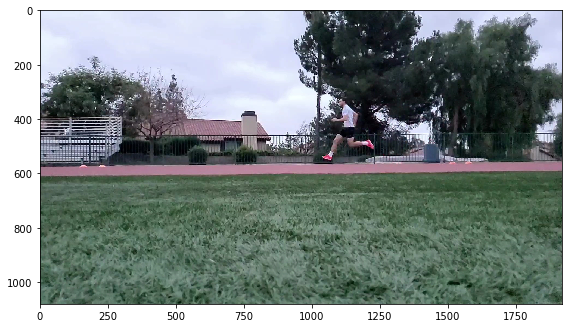

In [3]:
#Plot example image
image_file = './inputs/training_images/VideoCapture_20210814-112905.jpg'
#image_file = './inputs/training_images/VideoCapture_20210814-113854.jpg'
image = skimage.io.imread(image_file)

# original image
plt.figure(figsize=(8,6))
skimage.io.imshow(image)

Now we will apply the model.  As we can see, the model does a great job at identifying the person in the image. The mask is plotted below.

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


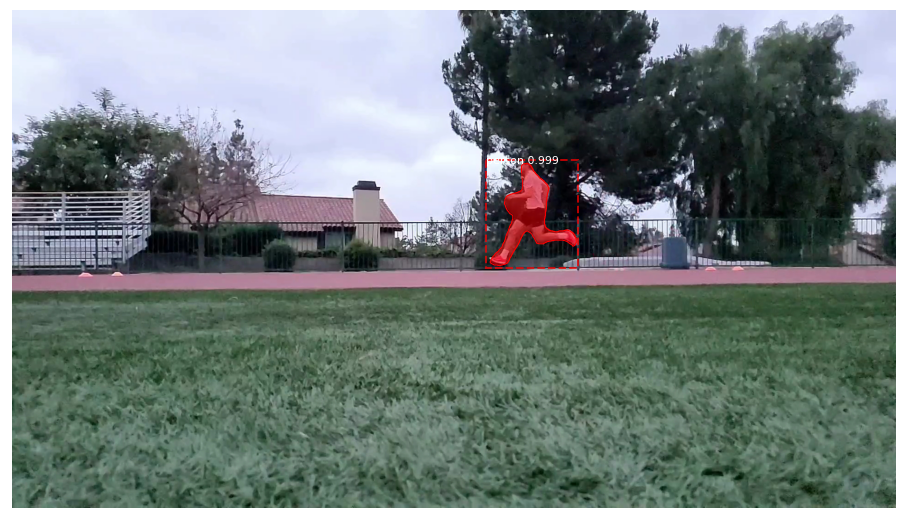

In [4]:
# apply model
results = person_model.detect([image], verbose=1)
r = results[0]

#plot image with mask and bounding box 
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

Now we can give a preview of how the model will be used later.  We get the mask of the person and calculate the centroid. This will allow us to later determine the horizontal relationship of the person in space relative to the cones. Below, we plot a minimalist representation of the mask, centroid, and vertical line to show the person's location.

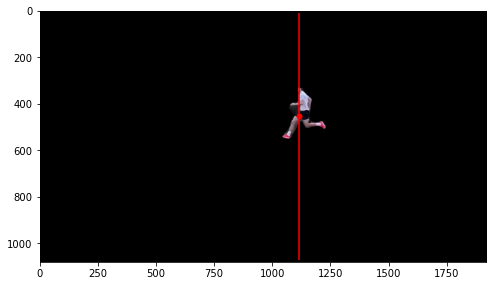

In [5]:
#Focus on just the mask
mask = r['masks']
mask = mask.astype(int)

#indicator for whether mask
for i in range(mask.shape[2]):
    image_mask = skimage.io.imread(image_file)
    for j in range(image_mask.shape[2]):
        image_mask[:,:,j] = image_mask[:,:,j] * mask[:,:,i]
    
#centroid of mask
y_centroid, x_centroid = np.argwhere(image_mask[:,:,0]==1).mean(axis=0)    

#plot mask and centroid
plt.figure(figsize=(8,8))
plt.imshow(image_mask)
#plt.imshow(image)
plt.vlines(x_centroid,ymin=10,ymax=image_mask.shape[0]-10,color="red")
plt.plot(x_centroid, y_centroid, marker='o', markersize=5, color="red")


## Mask R-CNN Model for Cone Instance Segmentation

Orange sports cones are not a common object, and not included in the COCO dataset, so we'll have to fit a model with our own custom dataset.  I did not include all the processing steps in this notebook to create the dataset, but an overview of the steps is provided in the intro of this notebook.

Below is the code to fit the model once the training data was established. First we set up the configuration, and then process the training images into a format used in the model.

A lot of this code is modified from [here](https://github.com/akTwelve/tutorials/blob/master/mask_rcnn/MaskRCNN_TrainAndInference.ipynb) and [here](https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/?utm_source=blog&utm_medium=introduction-image-segmentation-techniques-python).

In [11]:
class ConesConfig(Config):
    """Configuration for training on the orange cone dataset.
    Derives from the base Config class and overrides values specific
    to the cones dataset.
    """
    # Give the configuration a recognizable name
    NAME = "orange_cones"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (cone)

    # All of our training images are 1080x1920 (video captures from videos taken on phone)
    IMAGE_MIN_DIM = 1080
    IMAGE_MAX_DIM = 1920

    # Steps per epoch
    #STEPS_PER_EPOCH = 500
    STEPS_PER_EPOCH = 20 

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, this is downsized
    BACKBONE = 'resnet50'

    # Other specifications
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = ConesConfig()
#config.display()


In [7]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
                
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids


In [8]:
#training images
dataset_train = CocoLikeDataset()
dataset_train.load_data('./inputs/png_to_coco/training_images/orange_cones_coco_annotated.json', './inputs/png_to_coco/training_images')
dataset_train.prepare()

#validation images
dataset_val = CocoLikeDataset()
dataset_val.load_data('./inputs/png_to_coco/val_images/orange_cones_coco_annotated.json', './inputs/png_to_coco/val_images')
dataset_val.prepare()




We can plot a few of the training images and the masks showing cones.  We can see the variation of surfaces and lighting conditions used, which will hopefully make the model more robust to identifying cones in a wide range of contexts.

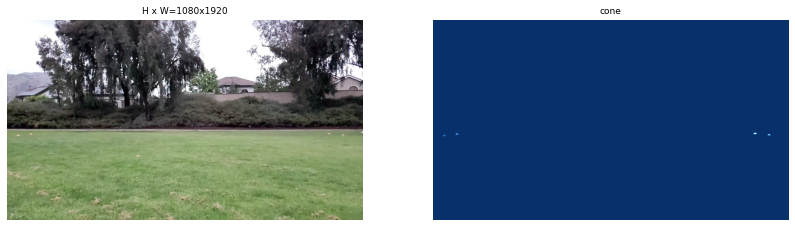

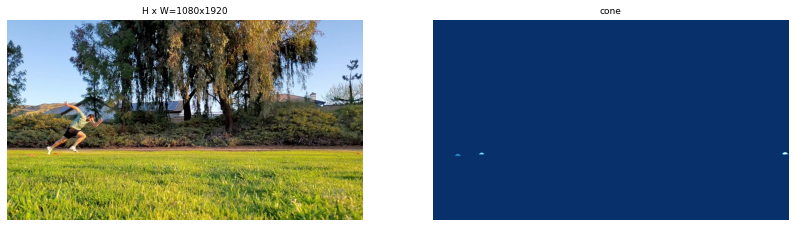

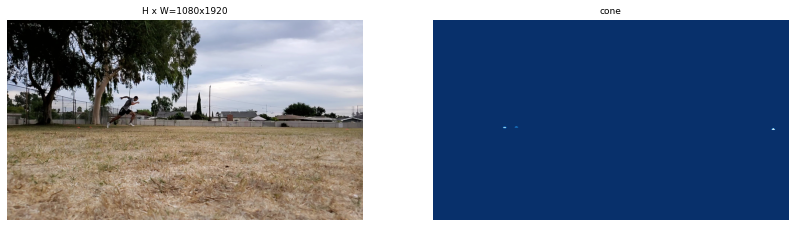

In [9]:
dataset = dataset_train
image_ids = dataset.image_ids

#Plot some examples of cones on different surfaces, and the associated mask layers
for image_id in image_ids[[3,5,8,11,12]]:
#for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names,limit=1)


Now we will fit the model.  The specifications I chose were to avoid too much computing time but produce a useable model.  In another context with a larger training dataset and if not running things on my local machine, I would have spent more time with this step in order to fit a better model.

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,model_dir=MODEL_DIR)

# start with COCO weights
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])


In [12]:
# Train the head branches
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')



Starting at epoch 0. LR=0.001

Checkpoint Path: logs\orange_cones20210818T1957\mask_rcnn_orange_cones_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4      

Now we'll set up a new inference class and test our model out on an example image.

In [14]:
class InferenceConfig2(ConesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.85
    
inference_config2 = InferenceConfig2()


In [15]:
# Recreate the model in inference mode
model_cone = modellib.MaskRCNN(mode="inference", config=inference_config2, model_dir=MODEL_DIR)


In [22]:
# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = 'logs\\orange_cones20210816T1729\\mask_rcnn_orange_cones_0004.h5'
#model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model_cone.load_weights(model_path, by_name=True)


Loading weights from  logs\orange_cones20210816T1729\mask_rcnn_orange_cones_0004.h5
Re-starting from epoch 4


In [23]:
#Test on example image
image_file = './inputs/training_images/VideoCapture_20210814-112905.jpg'
#image_file = './inputs/training_images/VideoCapture_20210814-113854.jpg'
image = skimage.io.imread(image_file)

results = model_cone.detect([image], verbose=1)
r = results[0]

class_names = ['BG',"cone"]

#plot
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1920, 1920, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1920.00000  int32
anchors                  shape: (1, 920700, 4)        min:   -0.04717  max:    1.01381  float32


The model did well in the example. We could use similar methods of determining the centroid of the cone as described above for the centroid of the person.  We'll get into that more in the next section where we put the pieces together.

## Processing an Input Video

### Load Video

First we will load the video and get some metadata.


In [24]:
#load Video
#video_file = './inputs/sprint_videos/Title_1.mp4'
video_file = './inputs/sprint_videos/20200617_071734_001.mp4'
vid = imageio.get_reader(video_file,  'ffmpeg')

#frames per second
#vid_fps = vid.get_meta_data()['fps']
#In this example we're pulling an editted slow-motion video (not the raw video) so I'm just going to hardcode the fps
vid_fps = 240

#total frames
if vid.get_meta_data()['nframes']==float('inf'):
    print("failed to pull nFrames from meta data...counting manually")
    temp = 0
    for num, image in enumerate(vid.iter_data()):
        temp += 1
    vid_nframe = temp
else:
    vid_nframe = vid.get_meta_data()['nframes']



failed to pull nFrames from meta data...counting manually


### Determine the location of the cones

We first create an "average image" of a sample of different frames to remove noise from moving objects.

Text(0.5, 1.0, 'Average Image from Sample of 30 random frames')

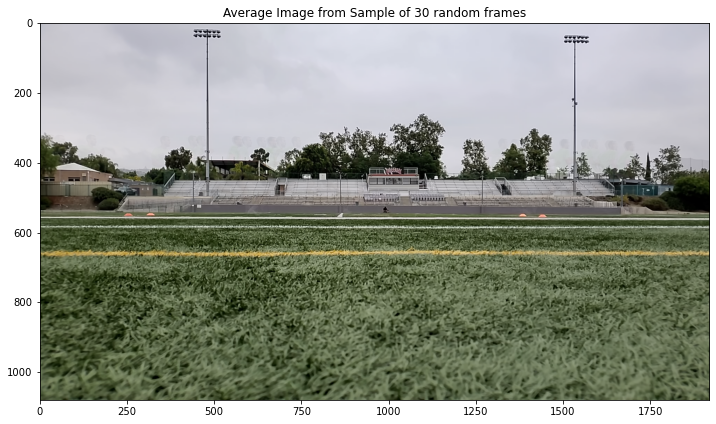

In [25]:
#Create single image with average RGB values of each pixel from sample of frames in the video

max_sample = 30
nsample = min(max_sample,vid_nframe)
sample_ind = np.random.choice(vid_nframe, nsample,replace=False)

#blank array
average_image = (vid.get_data(0)*0).astype('float64')

#loop over sample and compute "average image"
for ind in sample_ind:
    average_image += vid.get_data(ind)/max_sample
average_image = average_image.astype('uint8')

plt.figure(figsize=(12,8))
plt.imshow(average_image)
plt.title("Average Image from Sample of "+str(nsample)+" random frames")

Now we can apply our model

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1920, 1920, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1920.00000  int32
anchors                  shape: (1, 920700, 4)        min:   -0.04717  max:    1.01381  float32


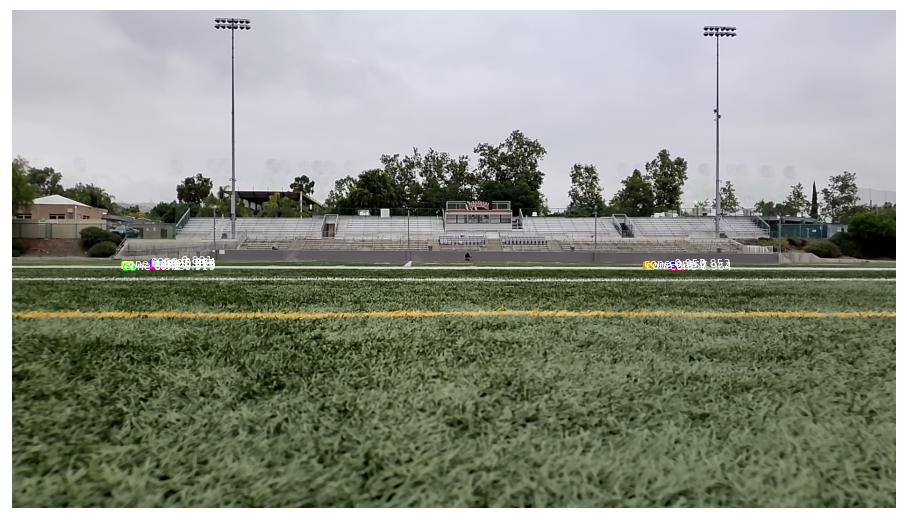

In [26]:
#Apply Mask R-CNN model to average image
results = model_cone.detect([average_image], verbose=1)
r = results[0]

class_names = ['BG',"cone"]

#plot
visualize.display_instances(average_image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

We see that several instances were predicted on the same cone location.  We therefore use K-means clustering (k=4) of each mask's centroid to reduce to 4 cone centroids like we need.

In [27]:
#We need 4 cones. Sometimes there are multiple cones identified on the same cone
cones_mask = r['masks']

#get centroids of each cone mask
if cones_mask.shape[2]==4: #if have 4, we are good to go
    print("Correct number of cones identified...")
    cone_centroids = []
    for i in range(cones_mask.shape[2]):
        y_centroid, x_centroid = np.argwhere(cones_mask[:,:,i]==True).mean(axis=0)    
        cone_centroids.append([x_centroid,y_centroid])

elif cones_mask.shape[2]<4:  #no fix for if we identify <4 cones yet
    raise ValueError('Less than 4 cones were detected.');
    
else:
    #add method for K-means clustering (k=4) to suggest the 4 cone placements if 
    print('More than 4 cones were detected...Applying K-means clustering');
    initial_cone_centroids = []
    for i in range(cones_mask.shape[2]):
        y_centroid, x_centroid = np.argwhere(cones_mask[:,:,i]==True).mean(axis=0)    
        initial_cone_centroids.append([x_centroid,y_centroid])

    kmeans = KMeans(n_clusters=4)
    kmeans.fit(initial_cone_centroids)
    cone_centroids = kmeans.cluster_centers_

More than 4 cones were detected...Applying K-means clustering


Once we have our 4 cone centroids, we determine the start/finish lines based on the average x-coordinate of each cone pair.

In [28]:
# identify start and finish lines, by average of 1st/2nd cones and 3rd/4th cones' x-centroids
# We don't need to know which is start/finish (i.e. running R-to-L or L-to-R), 
# since we can calculate the time as time between lines

left_start_finish = np.sort([msk[0] for msk in cone_centroids])[0:2].mean() 
right_start_finish = np.sort([msk[0] for msk in cone_centroids])[2:4].mean()   

#plot
plt.figure(figsize=(12,8))
plt.imshow(average_image)
plt.scatter( [msk[0] for msk in cone_centroids], [msk[1] for msk in cone_centroids],marker=".",color="red")
plt.vlines(left_start_finish,10,average_image.shape[0]-10,color="red",linestyles='dashed')
plt.vlines(right_start_finish,10,average_image.shape[0]-10,color="red",linestyles='dashed')
plt.title("Start/Finish Lines based on Detection of Cone Centroids")

Text(0.5, 1.0, 'Start/Finish Lines based on Detection of Cone Centroids')

### Determine location of person

This is just a function to determine the location of the person, since we'll need to do it in each frame.

In [29]:
#function to define location of person
def findSprinter(img):

    # apply model
    results = person_model.detect([img], verbose=1)
    r = results[0]
    mask = r['masks']
    mask = mask.astype(int)

    #raise error
    if mask.shape[2]==0:
        #nobody in frame
        x_centroid = None
    elif mask.shape[2]>1:
        #more than one person detected occasionally 
        #similarly to the cones, they masks are usually right next to each other
        #in this case taking the centroid of both masks works fine
        #What is not okay is if the video has many people in the background
        print("...More than one person detected...Assuming close together and take the centroid of both")
        image_mask = img.copy()
        image_mask[:,:,0] = image_mask[:,:,0] * mask[:,:,0]
        
        image_mask = img.copy()
        for j in range(image_mask.shape[2]):
            image_mask[:,:,j] = image_mask[:,:,j] * mask[:,:,0]

        y_centroid, x_centroid = np.argwhere(image_mask[:,:,0]==1).mean(axis=0)  

    else:
        #only one person detected...proceed
        image_mask = img.copy()
        image_mask[:,:,0] = image_mask[:,:,0] * mask[:,:,0]
        
        image_mask = img.copy()
        for j in range(image_mask.shape[2]):
            image_mask[:,:,j] = image_mask[:,:,j] * mask[:,:,0]

        y_centroid, x_centroid = np.argwhere(image_mask[:,:,0]==1).mean(axis=0)  
    
    if x_centroid == None:
        return None, None, None;
    else:
        return y_centroid, x_centroid, image_mask;
        



We can plot an example of one frame and how we relate the person location to the start/end line.

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both


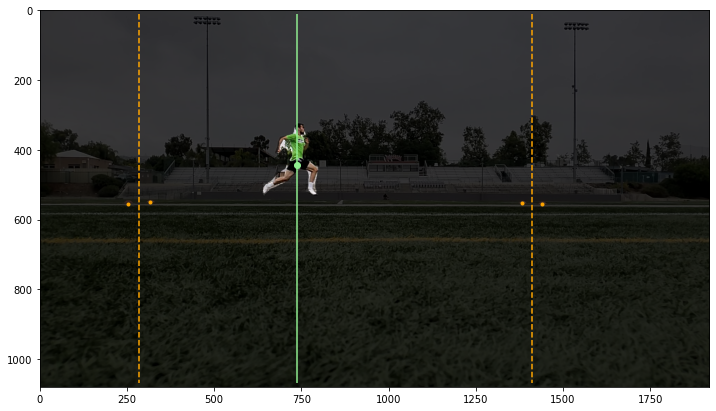

In [30]:
img= vid.get_data(150)

ex_y , ex_x, ex_mask = findSprinter(img)

#plot results
plt.figure(figsize=(12,8))
person_col = "lightgreen"
plt.imshow(img)
plt.imshow(ex_mask,alpha=.75)
plt.scatter( [msk[0] for msk in cone_centroids], [msk[1] for msk in cone_centroids],marker=".",color="orange")
plt.vlines(left_start_finish,10,average_image.shape[0]-10,color="orange",linestyles='dashed')
plt.vlines(right_start_finish,10,average_image.shape[0]-10,color="orange",linestyles='dashed')
plt.vlines(ex_x,ymin=10,ymax=image_mask.shape[0]-10,color=person_col)
plt.scatter([ex_x], [ex_y], marker='o', color=person_col)


Finally, we can loop through each frame and calculate the sprint time.

In the loop below, we 

- Determine sprinter location
- Record if sprinter is in timing zone
- Plot each frame which can be used to create a gif 

In [31]:
#loop over each frame where person is detected
fig, ax = plt.subplots(figsize=(12,8))
plt.axis('off')

timing_zone_ind = [0]*vid_nframe
gif_frames = []
sec_count = 0

for f_num in range(vid_nframe):
    print("Processing frame "+ str(f_num) + " out of "+str(vid_nframe)+"..." )
    
    #load video frame
    ex_img = vid.get_data(f_num)
    
    #get sprinter location
    ex_y , ex_x, ex_mask = findSprinter(ex_img)

    if ex_y == None: #no person detected in frame
        print("............no person in frame")
        pass;
    else: #person detected in frame ... 
        if ex_x > left_start_finish and ex_x < right_start_finish: #... and in timing zone
            person_col = "lightgreen"
            timing_zone_ind[f_num] += 1
            sec_count += 1/vid_fps
        else: #... not in timing zone
            person_col = "red"

        #Save plot to list
        im1 = ax.imshow(ex_img)
        im2 = ax.imshow(ex_mask,alpha=.75)
        im3 = ax.scatter( [msk[0] for msk in cone_centroids], [msk[1] for msk in cone_centroids],marker=".",color="orange")
        im4 = ax.vlines(left_start_finish,10,average_image.shape[0]-10,color="orange",linestyles='dashed')
        im5 = ax.vlines(right_start_finish,10,average_image.shape[0]-10,color="orange",linestyles='dashed')
        im6 = ax.vlines(ex_x,ymin=10,ymax=image_mask.shape[0]-10,color=person_col)
        im7 = ax.scatter([ex_x], [ex_y], marker='o', color=person_col)
        im8 = ax.text(ex_img.shape[1]/2,ex_img.shape[0]/10,"Sec= "+str(round(sec_count,2) ),color="lightgreen",fontsize="xx-large")
            
        gif_frames.append([im1,im2,im3,im4,im5,im6,im7,im8])
        

Processing frame 0 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 1 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assumi

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 16 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 17 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 32 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 33 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 48 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 49 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 64 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 65 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 80 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 81 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 96 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 97 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 112 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 113 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 128 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 129 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 144 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 145 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 

Processing frame 160 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing frame 161 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing frame 162 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 178 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 179 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 194 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 195 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 210 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing frame 211 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing frame 212 out of 359...
Pr

Processing frame 229 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing frame 230 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 231 out of 359...
Pr

molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 247 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 248 out of 359...
Processing 1 images
image                    shape: (1080, 192

molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 263 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 264 out of 359...
Processing 1 images
image                    shape: (1080, 192

molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 279 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 280 out of 359...
Processing 1 images
image                    shape: (1080, 192

Processing frame 294 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 295 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...As

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 310 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 311 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 326 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 327 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 342 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both
Processing frame 343 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 

...More than one person detected...Assuming close together and take the centroid of both
Processing frame 358 out of 359...
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
...More than one person detected...Assuming close together and take the centroid of both


Here is where we actually create the gif

In [32]:
#create animation with list of plots
ani_raw = animation.ArtistAnimation(fig, gif_frames, interval=10, blit=True, repeat_delay=0)

#Save GIFs (at Full and Half speed)
writergif = animation.PillowWriter(fps = vid_fps) 
ani_raw.save('sprint_animation.gif',writer=writergif)
writergif2 = animation.PillowWriter(fps = vid_fps/2) 
ani_raw.save('sprint_animation_half_speed.gif',writer=writergif2)

''

It's a simple calculation to compute the sprint time:  (Number of frames in the timing zone + 1)/fps

In [33]:
#Frames counted for timing
nFrames_timed = np.sum(timing_zone_ind)

#convert frames to seconds based on fps
seconds_timend = nFrames_timed / vid_fps
print("Time = " + str(round(seconds_timend,2)) + " sec" )



Time = 0.99 sec


As a QC check, we can also plot the important frames before/after the start/finish lines are broken.

57
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
58
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
294
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  m

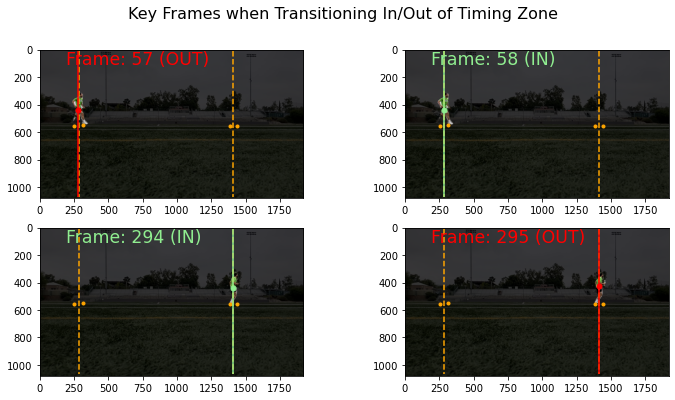

In [34]:
#Important Frames to consider frames before/after enter and exit the timing zone
in_zone_ind = [ i for i, x in enumerate(timing_zone_ind) if x==1] 
important_frames = [np.min(in_zone_ind)-1,np.min(in_zone_ind),np.max(in_zone_ind),np.max(in_zone_ind)+1]

fig, ax = plt.subplots(2,2,figsize=(12,6))
fig.suptitle("Key Frames when Transitioning In/Out of Timing Zone", fontsize=16)
ax = ax.ravel()

for frm in range(len(important_frames)):
    print(important_frames[frm])
    img= vid.get_data(important_frames[frm])
    results = person_model.detect([img], verbose=1)
    r = results[0]
    mask = r['masks']
    mask = mask.astype(int)

    image_mask = img.copy()
    for j in range(image_mask.shape[2]):
        image_mask[:,:,j] = image_mask[:,:,j] * mask[:,:,0]

    y_centroid, x_centroid = np.argwhere(image_mask[:,:,0]==1).mean(axis=0)    

    ax[frm].imshow(img)
    ax[frm].imshow(image_mask,alpha=.75)
    ax[frm].scatter( [msk[0] for msk in cone_centroids], [msk[1] for msk in cone_centroids],marker=".",color="orange")
    ax[frm].vlines(left_start_finish,10,average_image.shape[0]-10,color="orange",linestyles='dashed')
    ax[frm].vlines(right_start_finish,10,average_image.shape[0]-10,color="orange",linestyles='dashed')
    if x_centroid > left_start_finish and x_centroid < right_start_finish:
        ax[frm].vlines(x_centroid,ymin=10,ymax=image_mask.shape[0]-10,color="lightgreen")
        ax[frm].plot(x_centroid, y_centroid, marker='o', markersize=5, color="lightgreen")
        ax[frm].text(img.shape[1]/10,img.shape[0]/10,"Frame: "+str(important_frames[frm])+" (IN)",color="lightgreen",fontsize="xx-large")
    else:
        ax[frm].vlines(x_centroid,ymin=10,ymax=image_mask.shape[0]-10,color="red")
        ax[frm].plot(x_centroid, y_centroid, marker='o', markersize=5, color="red")
        ax[frm].text(img.shape[1]/10,img.shape[0]/10,"Frame: "+str(important_frames[frm])+" (OUT)",color="red",fontsize="xx-large")



That covers the process.  For the production code, things are just cleaned up to run more concisely with scripts and only produce the necesary outputs like the time and quality checks.